# Языковая модель на базе GRU

### Аннотация
В этой работе будет исследована зависимость качества языковой модели на базе GRU от ее параметров: эмбеддинга, скрытого представления, количества слоев и DropOutа. Модель будет обучена на корпусе из формулировок различных вопросов (из задачи Question Answering).

In [ ]:
!pip install torch --upgrade --quiet
!pip install torchdata --quiet
!pip install torchtext --upgrade --quiet

!rm -r language-modeling
!git clone https://github.com/antony-frolov/language-modeling --quiet

Здесь, возможно, придется перезапустить ядро...

In [2]:
import sys
source_path = '/kaggle/working/language-modeling/src'
if source_path not in sys.path:
    sys.path.append(source_path)

In [3]:
import torch
import torchtext
from torch.utils.data import DataLoader
from functools import partial
import numpy as np

from language_model import RNNLangModel, LMAccuracy, LMCrossEntropyLoss
from data_utils import tokenize, QuestionsDataset, collate_fn
from train_utils import train_and_save
from eval_utils import load_stats, plot_stats, continue_sentences

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

## Данные
В качества корпуса для обучения языковой модели возьмем вопросы из датасета SQuAD2 (корпус вопросов по тексту статей из Википедии и ответов на них из задачи Question Answering)

In [4]:
train_data = torchtext.datasets.SQuAD2(split='train')
test_data = torchtext.datasets.SQuAD2(split='dev')

In [5]:
def token_generator(dataset):
    for record in dataset:
        yield tokenize(record[1])

Ограничим словарь 30,000 токанами и добавим туда специальные токены `<pad>` (для паддинга), `<unk>` (для незнакомых слов), `<sos>` и `<eos>` (для начала и конца предложения соответственно).

Для токенизации предложения приводятся к нижнему регистру, производится unicode нормализация, все символы, не являющиеся маленькими латинскими буквами заменяются на пробелы, и предложение разбивается по пробелам.

In [6]:
max_tokens = 30000
specials = ['<pad>', '<unk>', '<sos>', '<eos>']
vocab = torchtext.vocab.build_vocab_from_iterator(token_generator(train_data), specials=specials,
                                                  special_first=True, max_tokens=max_tokens)
vocab.set_default_index(vocab['<unk>'])

Посмотрим как кодируются некоторые токены:

In [7]:
vocab.lookup_indices(['<pad>', '<unk>', 'where', 'is', 'mount', 'located'])

[0, 1, 29, 10, 2347, 78]

Ограничим наш корпус 50,000 обектов и обрежем длинные предложения до длины 20:

In [8]:
max_len = 20
size = 50_000
train_dataset = QuestionsDataset(train_data, vocab, max_len=max_len, pad_sos=True, pad_eos=True, size=size)
test_dataset = QuestionsDataset(test_data, vocab, max_len=max_len, pad_sos=True, pad_eos=True)

Посмотрим как выглядят входные данные:

In [9]:
train_dataset[0]

{'text': 'When did Beyonce start becoming popular?',
 'tokens': tensor([   2,   18,   11,  208,  150, 1529,  243,    3]),
 'tokens_len': tensor(8)}

Будем подавать данные батчами в 96 объектов. При этом предложения будут дополняться паддингом до самого длинного предложения в батче:

In [10]:
batch_size = 96
padding_value = vocab['<pad>']
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=1,
                              collate_fn=partial(collate_fn, padding_value=padding_value))
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=1,
                             collate_fn=partial(collate_fn, padding_value=padding_value))

Посмотрим на первое предложение в некотором батче:

In [11]:
batch = next(iter(train_dataloader))
print(batch['texts'][0])
print(batch['tokens'][:, 0])
print(batch['tokens_lens'][0])

Who prevents Ten Eyes from going online?
tensor([   2,   13, 3799, 1743, 3329,   28, 1590, 1782,    3,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
tensor(9)


## Обучение
Для последующего исследования были обучены модели, отличающиеся по:
- размеру эмбеддинга
- предобученности эмбединга
- размеру вектора скрытого состояния
- числу слоев GRU
- величине DropOut

В качестве предобученных эмбеддингов использовались GloVe эмбеддинги.

Конкретные конфигурации сетей можно посмотреть в следующей ячейке.

Конфигурации имеют формат:

```e<'g' if pretrained><embedding size>-h<hidden state size>-l<number of layers>-d<dropout fraction>```

In [12]:
emb_size_configs = [
    'e50-h256-l3-d05',
    'e100-h256-l3-d05',
    'e200-h256-l3-d05',
    'e300-h256-l3-d05'
]
g_emb_size_configs = [
    'eg50-h256-l3-d05',
    'eg100-h256-l3-d05',
    'eg200-h256-l3-d05',
    'eg300-h256-l3-d05'
]
hid_size_configs = [
    'e200-h64-l3-d05',
    'e200-h128-l3-d05',
    'e200-h256-l3-d05',
    'e200-h512-l3-d05'
]
num_layers_configs = [
    'e200-h256-l1-d05',
    'e200-h256-l3-d05',
    'e200-h256-l5-d05',
    'e200-h256-l7-d05'
]
dropout_configs = [
    'e200-h256-l3-d02',
    'e200-h256-l3-d04',
    'e200-h256-l3-d06',
    'e200-h256-l3-d08'
]
configs = emb_size_configs + g_emb_size_configs + hid_size_configs + num_layers_configs + dropout_configs

In [13]:
# !mkdir saved_models

Будем обучать все модели 10 эпох, в качетсве функции потерь выберем кросс-энтропию, к качестве оптимизатора выберем Adam с темпом обучения 1e-3 и weight decay 1e-6:

In [14]:
default_config = {'vocab': vocab, 'freeze': False}
default_train_config = {'train_loader': train_dataloader,
                'test_loader': test_dataloader,
                'loss_fn': LMCrossEntropyLoss(reduction='mean'),
                'optimizer_class': torch.optim.Adam,
                'optimizer_params': {'lr': 1e-3, 'weight_decay': 1e-6},
                'device': device,
                'num_epochs': 10,
                'verbose': False
}

model_class = RNNLangModel
# train_and_save(model_class, configs, default_config,
#                default_train_config, save_path, device)

## Исследование зависимостей
Будем отслежвать функцию потерь (кросс-энтропию) и точность на тренировочной и тестовой выборках. Не будем отслеживать перплексию, так как она является функцией кросс-энтропии (перплексия = 2^кросс энтропия).

Также для обученных моделей будем строить предложения по их началу (так как корпус состоит из вопросов, будем подавать начала вопросов). Для определенности при генерации будем случайно выбирать токен из top 3 самых вероятных пропорционально их вероятностям. Выберем следующие начала предложений:

In [15]:
save_path = '/kaggle/working/language-modeling/saved_models'

start_tokens = [
    ['<sos>', 'when', 'did'],
    ['<sos>', 'who', 'invented'],
    ['<sos>', '<pad>', '<pad>']
]

start_tokens_lens = [3, 3, 1]

### Размер эмбеддингов
Посмотрим как зависим качетсво модели от размера эмбеддингов токенов:

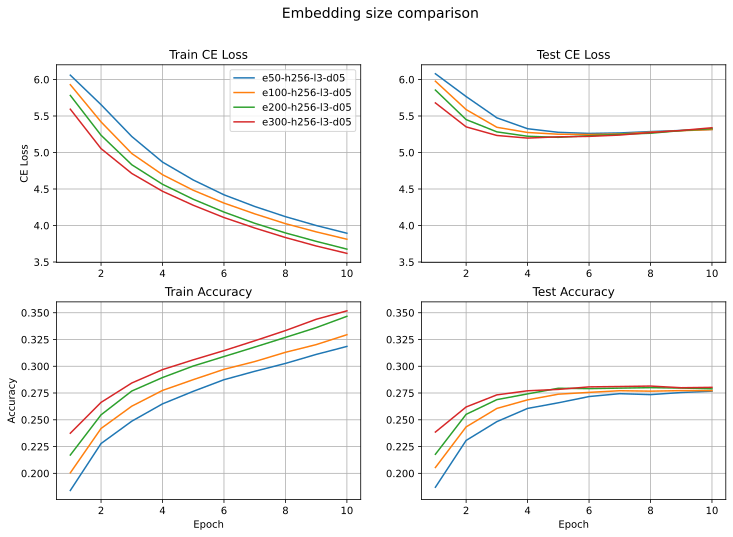

In [16]:
emb_size_stats = load_stats(emb_size_configs, save_path)
plot_stats(emb_size_stats, emb_size_configs, 'Embedding size comparison')

Как видно из графиков, чем больше размер эмбеддинга, тем выше качество на тренировочной выборке. На тестовой выборке после 10 эпох все модели показывают одинаковое качество, однако модели с большим размером эмбеддинга показывают лучшее качество в процессе обучения.

In [17]:
for config in emb_size_configs:
    print(config, end=':\n')
    for sent in continue_sentences(config, start_tokens, start_tokens_lens, save_path, top_k=3):
        print('\t' + sent)

e50-h256-l3-d05:
	<sos> when did the fbi s reign end <eos>
	<sos> who invented the first rabies as the largest <eos>
	<sos> how many years ago did the uk have <eos>
e100-h256-l3-d05:
	<sos> when did the deutscher werkbund end <eos>
	<sos> who invented the <unk> vaccine <eos>
	<sos> how many years did the torch relay take place <eos>
e200-h256-l3-d05:
	<sos> when did the first burning take control of the congo <eos>
	<sos> who invented the book <eos>
	<sos> how long was the first generation of the population of the city of southampton <eos>
e300-h256-l3-d05:
	<sos> when did the royal institute s army begin <eos>
	<sos> who invented the <unk> of the word heresy <eos>
	<sos> what was the name of a new anesthetic used to connect the torch s <eos>


## Предобученность эмбеддингов
Посмотрим как влияет предобученносить эмбеддингов на качество, сравних их с обученными с нуля:

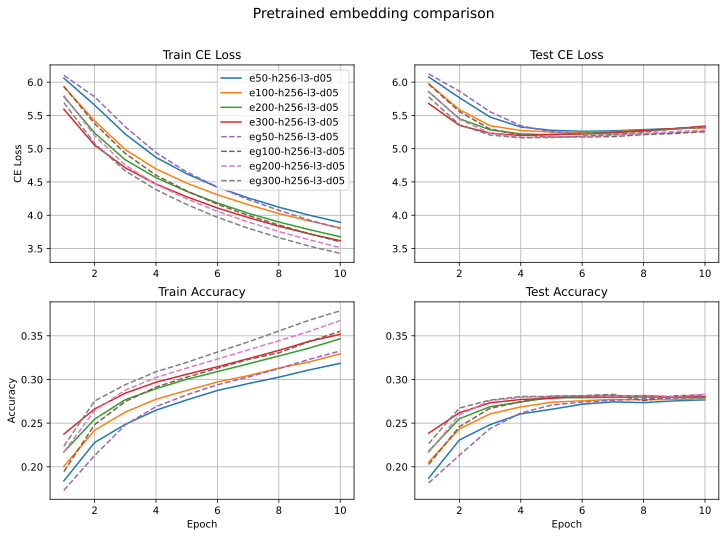

In [18]:
all_emb_size_configs = emb_size_configs + g_emb_size_configs
all_emb_size_stats = load_stats(all_emb_size_configs, save_path)
# g_emb_size_stats = load_stats(g_emb_size_configs, save_path)
plot_stats(all_emb_size_stats, all_emb_size_configs, 'Pretrained embedding comparison')
# plot_stats(g_emb_size_stats, g_emb_size_configs, 'Pretrained embedding size comparison')

Заметно, что предобученные эмбеддинги (прерывистые) показывают лучшее качество, чем не предобученные (сплошные) той же размерности. На тренировочной выборке они дают лучшее итоговое качество, а на тестовой прирост в качестве во время обучения.

In [19]:
for config in g_emb_size_configs:
    print(config, end=':\n')
    for sent in continue_sentences(config, start_tokens, start_tokens_lens, save_path, top_k=3):
        print('\t' + sent)

eg50-h256-l3-d05:
	<sos> when did the first commissioners council of nicaea end <eos>
	<sos> who invented the <unk> of the <unk> <eos>
	<sos> what was the first name in the first season of american idol <eos>
eg100-h256-l3-d05:
	<sos> when did the soviet union become the first republic of the russian federation <eos>
	<sos> who invented the first method of the word that is used to describe the <unk> <eos>
	<sos> what is the main term that can be used in the word <eos>
eg200-h256-l3-d05:
	<sos> when did the first council of nicaea occur <eos>
	<sos> who invented the term biology <eos>
	<sos> what is the term for a person who has been excluded with the messiah <eos>
eg300-h256-l3-d05:
	<sos> when did the torch arrive <eos>
	<sos> who invented the first browser <eos>
	<sos> what is an example of an organism that can be used in the interpretation of the language <eos>


Кажется, что предложения с предобученными эмбеддингами получаются чуть лучше, хотя сравнивать сложно.

## Размер вектора скрытого представления
Посмотрим как размер вектора скрытого представления влияет на качество решения задачи:

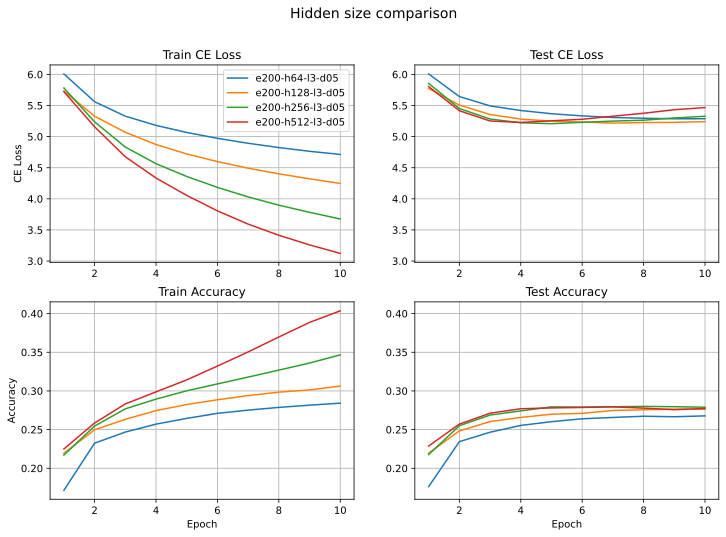

In [20]:
hid_size_stats = load_stats(hid_size_configs, save_path)
plot_stats(hid_size_stats, hid_size_configs, 'Hidden size comparison')

Можно заметить, что чем больше размер скрытого представления, тем больше переобучается модель на тренировочной выборке. Самый маленький размер скрытого представления (64) дает небольшое уменьшение точности на тестовой выборке. Самый большой размер скрытого представления (512) переобучается сильнее других и на последних эпохах кросс-энтропия такой модели начинает возрастать. В целом модели показывают похожее качетсво на тестовой выборке.

In [21]:
for config in hid_size_configs:
    print(config, end=':\n')
    for sent in continue_sentences(config, start_tokens, start_tokens_lens, save_path, top_k=3):
        print('\t' + sent)

e200-h64-l3-d05:
	<sos> when did the <unk> of the us begin in the world in a world system <eos>
	<sos> who invented the first institute for the united states <eos>
	<sos> what is the name of the <unk> that was the most language of <eos>
e200-h128-l3-d05:
	<sos> when did the <unk> of the united islands begin to be the first time of the united states <eos>
	<sos> who invented the <unk> of the <unk> <eos>
	<sos> how many people did the fbi sell <eos>
e200-h256-l3-d05:
	<sos> when did the first burning of the russian federation begin <eos>
	<sos> who invented the first major championship in new delhi <eos>
	<sos> how many people were injured on the first time <eos>
e200-h512-l3-d05:
	<sos> when did the royal institute celebrate the bbl league <eos>
	<sos> who invented the first bbl cup <eos>
	<sos> what did the british empire give to the roman empire <eos>


## Число слоев GRU
Посмотрим как зависит качетсво языковой модели в зависимости от числа рекуррентных слоев:

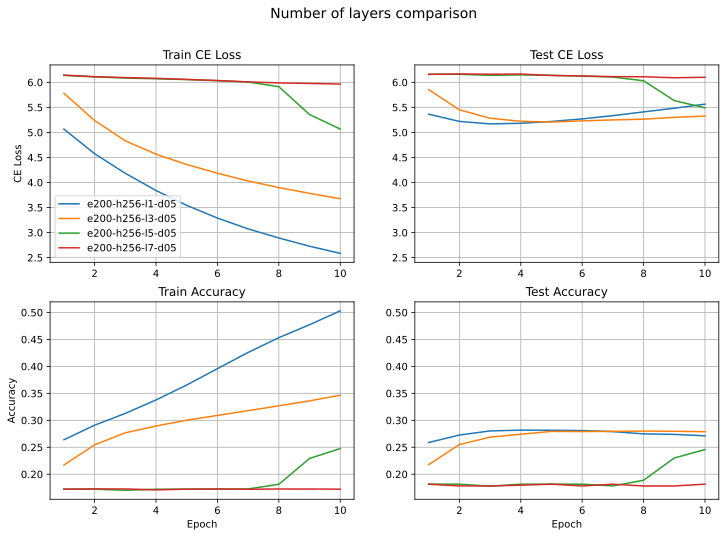

In [22]:
num_layers_stats = load_stats(num_layers_configs, save_path)
plot_stats(num_layers_stats, num_layers_configs, 'Number of layers comparison')

Можно заметить, что при 1 слое модель переобучается сильнее других. Это, вероятно, связано с тем, что при одном слое между слоями не добавляется DropOut. Модель с 7 слоями практически не обучается, модель с 5 слоями начинает обучаться лишь на 7-8 эпохе. Оптимальной можно назвать модель с 3 слоями. Она хорошо обучается, и не так сильно переобучается, как модель с 1 слоем.

In [26]:
for config in num_layers_configs:
    print(config, end=':\n')
    for sent in continue_sentences(config, start_tokens, start_tokens_lens, save_path, top_k=3):
        print('\t' + sent)

e200-h256-l1-d05:
	<sos> when did john goldsmith make his work on the <unk> of the <unk> <eos>
	<sos> who invented the term <unk> <eos>
	<sos> what is another term for the avignon papacy <eos>
e200-h256-l3-d05:
	<sos> when did the first council of nicaea take place <eos>
	<sos> who invented the first oral power of the rsfsr <eos>
	<sos> what was the first year to the flush vegas class <eos>
e200-h256-l5-d05:
	<sos> when did the fbi s end of the us of the us of the idol of <eos>
	<sos> who invented the first minister of the us <eos>
	<sos> what is the name of the first institute <eos>
e200-h256-l7-d05:
	<sos> when did the did the the <eos>
	<sos> who invented the the the <eos>
	<sos> what was of the of the of <eos>


Модель с 7 слоями плохо обучилась, и поэтому генерирует плохие (однородные и не похожие на настоящие) предложения.

## DropOut
Посмотрим как зависит качество модели от величины коэффициента DropOut:

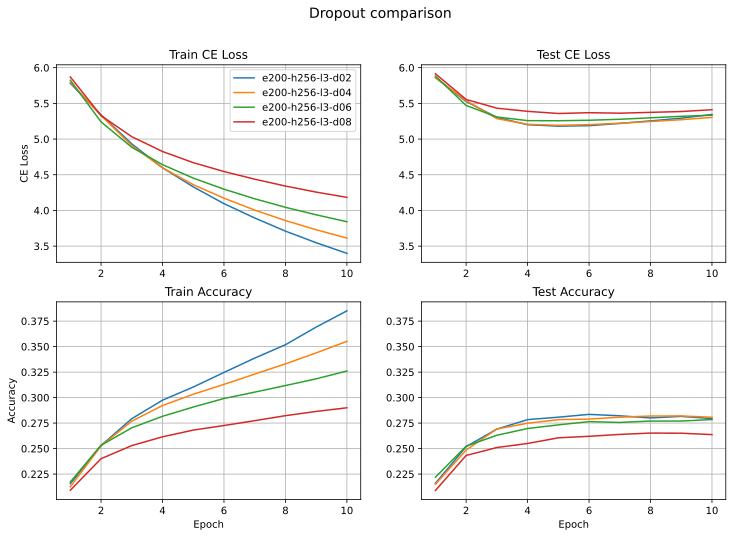

In [24]:
dropout_stats = load_stats(dropout_configs, save_path)
plot_stats(dropout_stats, dropout_configs, 'Dropout comparison')

Можно заметить, что чем меньше DropOut, тем выше качество на тренировочной выборке. При этом качество на тестовой выборке, не сильно зависит от коэффициета DropOut. Лишь для коэффициента 0.8 модель показывает на тестовой выборке качетсво хуже, чем другие.

In [25]:
for config in dropout_configs:
    print(config, end=':\n')
    for sent in continue_sentences(config, start_tokens, start_tokens_lens, save_path, top_k=3):
        print('\t' + sent)

e200-h256-l3-d02:
	<sos> when did the first draft of the island come into <eos>
	<sos> who invented the term multiframe <eos>
	<sos> what is the average rainfall in plymouth <eos>
e200-h256-l3-d04:
	<sos> when did the first world war take place <eos>
	<sos> who invented the chapter house <eos>
	<sos> what did the church do in <eos>
e200-h256-l3-d06:
	<sos> when did the first government begin to regulate a vanity system <eos>
	<sos> who invented that the sclaveni was the same to the <unk> <eos>
	<sos> what was the name of the second satellite that could be used to describe the torch <eos>
e200-h256-l3-d08:
	<sos> when did the faa become a part of the united islands <eos>
	<sos> who invented the term the lucky rabbit in the world of the soviet states <eos>
	<sos> what does the word call the <unk> <eos>


# Выводы
Из проведенных исследований  можно сделать вывод, что при обучении языковой модели на основе GRU:
- лучше использовать предобученные эмбеддинги, а не обучать их с нуля (так модель быстрее обучается)
- размер эмбеддингов не так важен (возможно это изменится при увеличении размера словаря и корпуса)
- лучше не брать слишком мальнький и слишком большой размер вектора скрытого представления (брать 128-256)
- лучше брать больше одного слоя (чтобы работал DropOut), и не брать больше 2-4 слоев)
- Dropout уменьшает переобучение, но почти не влияет на качество (лучше брать до 0.7)